In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import os
import itertools
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.optimize import golden

import configs
from utils import utils
from utils import laion_utils as laionu
from core.queries import QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Settings

## Columns

In [4]:
q_type = QueryType.NAME_DEF
q_key = 'wnid'
clip_ver = configs.CLIPConfig.DEFAULT_VERSION

txt2q_sim_col = f'text_to_{q_type}_{q_key}_similarity_{clip_ver}'
img2q_sim_col = f'image_to_{q_type}_{q_key}_similarity_{clip_ver}'
    
print(txt2q_sim_col)
print(img2q_sim_col)

text_to_name_def_wnid_similarity_clip-vit-base-patch32
image_to_name_def_wnid_similarity_clip-vit-base-patch32


## Path

In [5]:
# LAION subset
laion_path = 'laion400m'
laion_until_part = configs.LAIONConfig.NUM_PARTS - 1
prefix = configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_LARGE_PREFIX, txt2q_sim_col)

subset_file_name = prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)
subset_file_path = os.path.join(laion_path, subset_file_name)

print(subset_file_path)

# Labels (maps)
labels_path = os.path.join(laion_path, 'processed', 'ilsvrc_labels')
labels_filter = f'wnid2laionindices({prefix}).pkl'

laion400m/subset_sm_large_filt(text_to_name_def_wnid_similarity_clip-vit-base-patch32)_part-00000-to-part00031-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet


## Thresholds 

In [6]:
ref_txt2q_sim_th = 0.82
ref_img2q_sim_th = 0.2

min_txt2q_sim_th = 0.72

n_th = 11

# Load

## Load LAION subset

In [7]:
df = pd.read_parquet(subset_file_path)

df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,name_def_wnid,text_to_name_def_wnid_similarity_clip-vit-base-patch32,text_to_name_def_wnid_similarity_bert-base-uncased,text_to_name_def_wnid_similarity_all-mpnet-base-v2,image_to_name_def_wnid_similarity_clip-vit-base-patch32
69,1.127880e+12,http://images4-b.ravelrycache.com/uploads/Wool...,Oval_drum_small2,320.0,320.0,?,UNLIKELY,0.306868,drum which is a musical percussion instrument;...,0.853099,0.754025,0.430411,0.310998
109,1.589540e+11,https://gigbucks.com/pics/t2/24858-1.jpg?13980...,setup your professional ★wordpress★ site withi...,102.0,72.0,?,UNLIKELY,0.323601,web site which is a computer connected to the ...,0.780191,0.936202,0.288167,NaN
115,2.770960e+11,https://thumbs.dreamstime.com/t/heart-violin-2...,Heart and violin! Stock Photo,240.0,160.0,?,UNLIKELY,0.311043,violin which is bowed stringed instrument that...,0.754790,0.941458,0.340364,0.293216


## Load maps

In [8]:
wnid_maps_paths = glob.glob(os.path.join(labels_path, labels_filter))

wnid_maps = []
for path in tqdm(wnid_maps_paths):
    with open(path, 'rb') as f:
        wnid2laionindices_i = pickle.load(f)
        wnid_maps.append(wnid2laionindices_i)
        del wnid2laionindices_i
        
wnid2laionindices = utils.join_maps(wnid_maps)
laionindex2wnids = utils.find_inverse_map(wnid2laionindices)
del wnid_maps

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


# Sweep the thresholds

In [9]:
def num_samples(txt2q_th, img2q_th):
    return np.sum((df[txt2q_sim_col] >= txt2q_th) & (df[img2q_sim_col] >= img2q_th))

In [10]:
def num_wnids(txt2q_th, img2q_th):
    filt_df = df[(df[txt2q_sim_col] >= txt2q_th) & (df[img2q_sim_col] >= img2q_th)]
    
    filt_wnids = set([laionindex2wnids[laion_idx][0] for laion_idx in filt_df.index])
    
    return len(filt_wnids)

In [11]:
txt2q_ths = np.linspace(min_txt2q_sim_th, ref_txt2q_sim_th, n_th)

## _Fixed number of samples_

In [12]:
ref_n_sample = num_samples(ref_txt2q_sim_th, ref_img2q_sim_th)

In [13]:
loss = lambda img_th, txt_th: np.abs(ref_n_sample - num_samples(txt_th, img_th))

In [14]:
opt_fixed_samples_img2q_ths = np.zeros((n_th,))

for i_th, txt2q_th in enumerate(tqdm(txt2q_ths)):
    opt_fixed_samples_img2q_ths[i_th] = golden(loss, args=(txt2q_th,), brack=(ref_img2q_sim_th, 1.))
    
print(np.concatenate([txt2q_ths.reshape((-1, 1)), opt_fixed_samples_img2q_ths.reshape((-1, 1))], axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.05it/s]

[[0.72       0.30367875]
 [0.73       0.30223105]
 [0.74       0.30055377]
 [0.75       0.29847732]
 [0.76       0.29594797]
 [0.77       0.29279259]
 [0.78       0.28862727]
 [0.79       0.28279885]
 [0.8        0.27392283]
 [0.81       0.25793993]
 [0.82       0.20000104]]


In [15]:
chosen_txt2q_ths = [0.72, 0.76, 0.79, 0.81]
chosen_img2q_ths = [0.3037, 0.2959, 0.2828, 0.2579]

for i_th in range(len(chosen_txt2q_ths)):
    print(num_samples(chosen_txt2q_ths[i_th], chosen_img2q_ths[i_th]), 
          num_wnids(chosen_txt2q_ths[i_th], chosen_img2q_ths[i_th]))

534196 922
535482 922
534649 919
534824 911


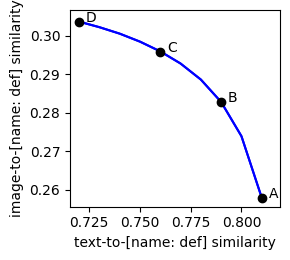

In [16]:
plt.figure(figsize=(3, 2.7))

plt.plot(txt2q_ths[:-1], opt_fixed_samples_img2q_ths[:-1], 'b')
plt.plot(txt2q_ths[:-1], opt_fixed_samples_img2q_ths[:-1], 'b')

plt.plot(chosen_txt2q_ths, chosen_img2q_ths, 'ko')

assert len(chosen_txt2q_ths) == 4
tags = ['D', 'C', 'B', 'A']
for i_c in range(4):
    plt.text(chosen_txt2q_ths[i_c] + 0.0033, chosen_img2q_ths[i_c], tags[i_c])

plt.xlabel('text-to-[name: def] similarity')
plt.ylabel('image-to-[name: def] similarity')

plt.xlim(right=chosen_txt2q_ths[-1] + 0.009)
plt.ylim(top=chosen_img2q_ths[0] + 0.003)

plt.tight_layout()

plt.savefig(os.path.join('figs', f'mm_filt_frontier_fixed_n_sample.pdf'), bbox_inches='tight')

## _Fixed number of WNIDs_

In [17]:
ref_n_wnid = num_wnids(ref_txt2q_sim_th, ref_img2q_sim_th)

In [18]:
loss = lambda img_th, txt_th: np.abs(ref_n_wnid - num_wnids(txt_th, img_th))

In [19]:
opt_fixed_wnids_img2q_ths = np.zeros((n_th,))

for i_th, txt2q_th in enumerate(tqdm(txt2q_ths)):
    opt_fixed_wnids_img2q_ths[i_th] = golden(loss, args=(txt2q_th,), brack=(ref_img2q_sim_th, 1.))
    
print(np.concatenate([txt2q_ths.reshape((-1, 1)), opt_fixed_wnids_img2q_ths.reshape((-1, 1))], axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:44<00:00, 14.94s/it]

[[0.72       0.31182018]
 [0.73       0.31064277]
 [0.74       0.30964961]
 [0.75       0.30690586]
 [0.76       0.3058033 ]
 [0.77       0.30423233]
 [0.78       0.30331656]
 [0.79       0.29840919]
 [0.8        0.29143756]
 [0.81       0.27828133]
 [0.82       0.24423438]]


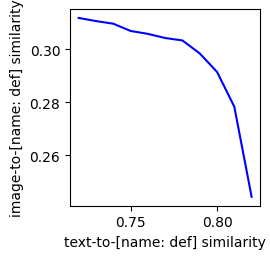

In [20]:
plt.figure(figsize=(3, 2.7))

plt.plot(txt2q_ths, opt_fixed_wnids_img2q_ths, 'b')

plt.xlabel('text-to-[name: def] similarity')
plt.ylabel('image-to-[name: def] similarity')

plt.tight_layout()